In [9]:
import warnings

warnings.filterwarnings(action='once', category=FutureWarning)
warnings.filterwarnings(action='once', category=UserWarning)
warnings.filterwarnings(action='once', category=DeprecationWarning)

import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import numpy as np
import datetime

In [10]:
from daylength import daylength

In [11]:
data_path = 'data/'

In [12]:
pd.set_option('display.max_rows', 300)

In [13]:
# This notebook is used to create the training data for our observations

# "Observations" are unique by 
#   1. Season (e.g. year - 2019, 2020, ...)
#   2. ZCTA (effectively zip code)

# So there will be num_counties x num_seasons time series observations
# Morel season is defined as January - June
# (based on earliest and latest observations + buffer ahead of time for time series data

# The output format will be 
# Holdout set: 2023 season
# Training set: 2019-2022 seasons
# Morel season is defined as the earliest and latest dates a morel was spotted within a county
# Initial features are TMAX, TMIN, Precipitation, Day length
# Eventually want a dataframe that has
#   - Observation ID (year + county)
#   - Year
#   - County
#   - Day (YYYYMMDD - used to order within observation)
#   - Tmax
#   - Tmin
#   - Precipitation
#   - Day length

# We will only consider counties in which there were morel observations as our model,
# but we will do inference on ANY county, provided we have recent weather data


In [14]:
def fill_missing_timedeltas(group, col_name):
    # Ensure the group is sorted by some time column if your data has an order
    # group = group.sort_values('some_other_time_column')  # Uncomment and adjust if needed

    # Forward fill and backward fill to prepare for averaging
    forward_filled = group[col_name].fillna(method='ffill')
    backward_filled = group[col_name].fillna(method='bfill')
    
    # Combine the two fill methods to find the average (convert to microseconds for averaging)
    average_timedelta = (forward_filled.dt.total_seconds() + backward_filled.dt.total_seconds()) / 2
    group[col_name] = pd.to_timedelta(average_timedelta, unit='s')

    # Handle cases where the first or last elements are still missing (if any)
    if pd.isnull(group[col_name].iloc[0]):
        group[col_name].fillna(method='bfill', inplace=True)
    if pd.isnull(group[col_name].iloc[-1]):
        group[col_name].fillna(method='ffill', inplace=True)

    return group


In [15]:
def calculate_in_season(group, X=30):
    group = group.reset_index(drop=True)  # Reset index for proper iteration
    group = group.sort_values(['date_dateobj']) # Sort based on date
    group['in_season'] = 0  # Initialize the 'in_season' column
    
    # Forward pass to determine the start of in_season periods
    for i in range(len(group)):
        if group.loc[i, 'observation'] == 1:
            group.loc[i, 'in_season'] = 1
            # Check ahead within X days for another observation3
            for j in range(1, X+1):
                if i+j < len(group) and group.loc[i+j, 'observation'] == 1:
                    group.loc[i+1:i+j, 'in_season'] = 1
                    break
    return group

In [16]:
def apply_rolling(group, window=9, min_periods=1, center=True):
    # Use rolling window to determine 'target', adjusting the 'min_periods' if necessary
    group = group.sort_values('date_dateobj')  # Sort by date 
    group['target'] = group['observation'].rolling(window=window, min_periods=min_periods, center=center).max()
    return group

In [17]:
def apply_gaussian_decay(group, sigma=4):
    n = len(group)
    weights = np.zeros(n)

    # As the group is already sorted, we assume 'date_dateobj' sorting is handled outside this function
    # Convert local indices to global indices because the group's index might not start from 0
    global_idx = group.index

    # Identifying the positions of '1's within the group
    ones_indices = group[group['observation'] == 1].index

    # Apply Gaussian decay around each '1'
    for idx in ones_indices:
        local_idx = group.index.get_loc(idx)  # Get local position of the index within the group
        start = max(0, local_idx - 3 * sigma)
        end = min(n, local_idx + 3 * sigma + 1)

        # Convert local index range back to global index range
        global_start = global_idx[start]
        global_end = global_idx[end - 1] + 1  # slice end is exclusive

        # Indices array for the Gaussian calculation
        index_array = np.arange(global_start, global_end)
        weights[start:end] += np.exp(-0.5 * ((index_array - idx) / sigma) ** 2)

    group['gaussian_target'] = np.clip(weights, a_min=0., a_max=1.)
    return group

In [18]:
def preprocess_observations(observation_df, year, fips_data, zcta_bounds):
    # Correct usage of the function's argument for morel observations
    points_within_counties = gpd.sjoin(observation_df, fips_data, how="inner", op="within").drop(columns=['index_right'])
    points_within_zctas = gpd.sjoin(points_within_counties, zcta_bounds, how="inner", op="within")
    
    select_cols = ['markername', 'lat', 'lon', 'marker-createdon', "NAME", "ZCTA5CE10", 'zcta_centroid', 'fips_centroid']
    if not all(col in points_within_zctas.columns for col in select_cols):
        raise ValueError("Some required columns are missing from the DataFrame")
    new_df = points_within_zctas[select_cols]

    # Extracting year, month, and day as strings and forming a proper date string
    new_df['year'] = observation_df['marker-createdon'].dt.year.astype(str)
    month = observation_df['marker-createdon'].dt.month.astype(str).str.zfill(2)
    day = observation_df['marker-createdon'].dt.day.astype(str).str.zfill(2)
    new_df['processed_date'] = new_df['year'] + month + day
    
    # Filtering for observations within the specified year
    start_date = datetime.datetime(year, 1, 1)
    end_date = datetime.datetime(year, 7, 1)
    new_df = new_df[(new_df['marker-createdon'] >= start_date) & (new_df['marker-createdon'] < end_date)]
    
    new_df['observation'] = 1
    return new_df.reset_index(drop=True)

In [19]:
def preprocess_weather(weather_df):
    """Give weather DF necessary columns"""
    keep_cols = ['county_name', 'fips', 'date', 'ppt', 'tmax', 'tmin', 'tavg', 'zipcode']
    new_df = weather_df[(keep_cols)]
    new_df['fips_pad'] = new_df['fips'].apply(str).str.zfill(5)
    new_df['year'] = new_df['date'].astype(str).str[:4]
    new_df['ZCTA5CE10'] = new_df['zipcode'].apply(str).str.zfill(5)
    new_df['date'] = new_df['date'].apply(str)
    return new_df

In [20]:
def process_boundary_data(bounds, prefix, boundary_code_col, n_pad):
    new_bounds = bounds
    new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
    new_bounds[f"{boundary_code_col}_pad"] = new_bounds[boundary_code_col].apply(str).str.zfill(n_pad)
    return new_bounds

In [21]:
def load_weather_data_for_year(year, level='zcta'):
    """
    Bulk load weather data available for year. Does this for a given year
    (during morel season) at the granularity given at 'level'. Assumes
    data is present in data directory.
    
    Weather data originally downloaded from here: https://asmith.ucdavis.edu/data/prism-weather
    and https://files.asmith.ucdavis.edu/weather/temporalUnit/spatialUnit_weighting/yyyymm.csv 
    EX: https://files.asmith.ucdavis.edu/weather/daily/zip_noweight/202301.csv 
    """
    weather_data_separate = []
    for month in ['01', '02', '03', '04', '05', '06']:
        obs = pd.read_csv(f'{data_path}weather/{str(year)}/{str(year)}{month}_{level}_weather_daily.csv')
        weather_data_separate.append(preprocess_weather(obs))
    weather_data_combined = pd.concat(weather_data_separate)
    return weather_data_combined

In [22]:
# Load geometries with centroids to approximate day length
# This was downloaded from here: https://github.com/plotly/datasets/blob/master/geojson-counties-fips.json
fips_bounds = gpd.read_file(f'{data_path}bounds/geojson-counties-fips.json')
fips_bounds_processed = process_boundary_data(fips_bounds, 'fips', 'id', 5)
# ZCTA data taken from here: https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_us_zcta510_500k.zip
zcta_bounds = gpd.read_file(f'{data_path}bounds/zip_bounds_2019.shp')
zcta_bounds_processed = process_boundary_data(zcta_bounds, 'zcta', 'ZCTA5CE10', 5)

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid


### Load all the data - do some data exploration

In [23]:
# Morel sightings data taken from great morel: https://www.thegreatmorel.com/morel-sightings/
morel_observations = gpd.read_file('data/morels/2023_sightings_greatmorel_full.json')

In [24]:
preprocessed_observations = preprocess_observations(morel_observations, 2023, fips_bounds, zcta_bounds)

/opt/miniconda3/envs/base_312/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/miniconda3/envs/base_312/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3873511372.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  points_within_zctas = gpd.sjoin(points_within_counties, zcta_bounds, how="inner", op="within")


In [25]:
gpd.sjoin(morel_observations, zcta_bounds, how="inner", op="within")

/opt/miniconda3/envs/base_312/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/2717557521.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269

  gpd.sjoin(morel_observations, zcta_bounds, how="inner", op="within")


,markerid,layers,requested_layer,markername,basemap,lat,lon,icon,zoom,iconUrl,...,mlm_filter_details,geometry,index_right,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,zcta_centroid,ZCTA5CE10_pad
0,6516,[46],[46],"90066 Venice, CA 02/04/2023",stamen_terrain,33.987540,-118.472150,mfeb.png,10,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-118.47215 33.98754),30178,90291,8600000US90291,90291,6470939,866771,POINT (-118.46344 33.99437),90291
1,6517,[46],[46],"96778 Pahoa, HI 02/04/2022",stamen_terrain,19.623904,-155.043945,mfeb.png,9,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-155.04395 19.62390),27632,96749,8600000US96749,96749,162781878,9936840,POINT (-155.00156 19.60753),96749
2,6518,[46],[46],"30223 Griffen, GA 02/10/2023",osm_mapnik,33.247100,-84.263600,mfeb.png,9,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-84.26360 33.24710),19217,30224,8600000US30224,30224,171287878,2682341,POINT (-84.23683 33.20485),30224
3,6519,[46],[46],37862 Sevierville. TN 02/17/2022,osm_mapnik,35.869260,-83.567670,mfeb.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-83.56767 35.86926),3074,37862,8600000US37862,37862,217610175,0,POINT (-83.61250 35.77803),37862
4,6520,[46],[46],"31836 Woodland, GA 02/19/2023",osm_mapnik,32.788380,-84.562340,mfeb.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-84.56234 32.78838),2108,31836,8600000US31836,31836,214398995,3093161,POINT (-84.53996 32.79703),31836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,7722,[48],[48],"98586 Raymond, WA 04/16/2023",mapquest_osm,46.696917,-123.705063,mapr.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-123.70506 46.69692),7343,98577,8600000US98577,98577,991260466,25958296,POINT (-123.60769 46.64218),98577
1193,7723,[50],[50],"84010 Bountiful, UT 06/13/2023",mapquest_osm,40.884020,-111.878400,mjun.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-111.87840 40.88402),26882,84010,8600000US84010,84010,38953729,55354,POINT (-111.86726 40.86775),84010
1194,7724,[50],[50],"84535 Monticello, UT 06/21/2023",mapquest_osm,37.870990,-109.342900,mjun.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-109.34290 37.87099),7312,84535,8600000US84535,84535,4871965573,4194586,POINT (-109.56779 37.99929),84535
1196,8270,[48],[48],"66030 Gardner, KS 04/07/2024",osm_mapnik,38.811020,-94.927270,mapr.png,11,https://www.thegreatmorel.com/wp-content/uploa...,...,,POINT (-94.92727 38.81102),2378,66030,8600000US66030,66030,122654008,1259211,POINT (-94.94123 38.81502),66030


In [26]:
county_bounds = gpd.read_file('data/bounds/counties.geojson')

In [27]:
def load_and_process_geographic_data(data_path):
    fips_bounds = gpd.read_file(f'{data_path}bounds/geojson-counties-fips.json')
    fips_bounds_processed = process_boundary_data(fips_bounds, 'fips', 'id', 5)
    zcta_bounds = gpd.read_file(f'{data_path}bounds/zip_bounds_2019.shp')
    zcta_bounds_processed = process_boundary_data(zcta_bounds, 'zcta', 'ZCTA5CE10', 5)
    return fips_bounds_processed, zcta_bounds_processed

In [28]:
def load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_processed):
    morel_observations = gpd.read_file(f'{data_path}/morels/{year}_sightings_greatmorel_full.json')
    processed_observations = preprocess_observations(morel_observations, year, fips_bounds_processed, zcta_bounds_processed)
    return processed_observations

In [29]:
def get_relevant_weather_data(weather_data, processed_observations):
    observation_zctas = pd.DataFrame(processed_observations['ZCTA5CE10'].unique(), columns=['ZCTA5CE10'])
    weather_data_subset = pd.merge(weather_data, observation_zctas, how='inner', on=['ZCTA5CE10']).drop_duplicates()
    return weather_data_subset

In [30]:
def integrate_weather_data(weather_data, processed_observations):
    return pd.merge(weather_data, processed_observations[['ZCTA5CE10', 'processed_date', 'observation']].drop_duplicates(),
             how='left', left_on=['ZCTA5CE10', 'date'], right_on=['ZCTA5CE10', 'processed_date']).fillna({'observation': 0})

In [31]:
def merge_with_zcta_centroids(weather_data_subset, zcta_bounds_processed):
    weather_data_subset = pd.merge(weather_data_subset, zcta_bounds_processed[['ZCTA5CE10', 'zcta_centroid']].drop_duplicates(), how='inner', on=['ZCTA5CE10'])
    weather_data_subset['zcta_centroid_longitude'] = weather_data_subset.zcta_centroid.map(lambda p: p.x)
    weather_data_subset['zcta_centroid_latitude'] = weather_data_subset.zcta_centroid.map(lambda p: p.y)
    return weather_data_subset

In [32]:
def create_time_features(weather_with_observations):
    weather_with_observations['date_dateobj'] = pd.to_datetime(weather_with_observations['date'], format='%Y%m%d')
    weather_with_observations = weather_with_observations.sort_values(by=['ZCTA5CE10', 'date'])
    weather_with_observations['time_idx'] = weather_with_observations.groupby('ZCTA5CE10').cumcount() + 1
    return weather_with_observations

In [33]:
def finalize_training_data(weather_data):
    weather_data['day_length'] = weather_data.apply(lambda x: daylength.compute_day_length(x.zcta_centroid_latitude, x.zcta_centroid_longitude, x.date_dateobj), axis=1)
    weather_data = weather_data.groupby('ZCTA5CE10').apply(fill_missing_timedeltas, col_name='day_length')
    weather_data['day_length_seconds'] = weather_data.day_length.map(lambda x: round(x.total_seconds(), 2))
    weather_data['group'] = weather_data['ZCTA5CE10'] + weather_data['year'].astype(str)
    return weather_data.reset_index(drop=True).drop(columns=['zipcode', 'zcta_centroid'])

In [34]:
def apply_rolling_targets(weather_data, window_size):
    weather_data = weather_data.sort_values(['date_dateobj'])
    return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)

In [35]:
def apply_gaussian_targets(weather_data):
    
    weather_data = weather_data.sort_values(['date_dateobj'])
    return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_gaussian_decay(group)).reset_index(drop=True)

In [36]:
def chain_observations(weather_data, proximity_days):
    return weather_data.groupby('ZCTA5CE10').apply(lambda group: calculate_in_season(group, X=proximity_days)).reset_index(drop=True)

In [37]:
def finalize_targets(weather_data):
    weather_data['final_target'] = ((weather_data['target'].astype(bool)) | (weather_data['in_season'].astype(bool))).astype(int)
    weather_data['final_gaussian_target'] = np.maximum(weather_data['gaussian_target'], weather_data['in_season'])
    return weather_data

In [38]:
def create_training_data(year, data_path):
    fips_bounds_processed, zcta_bounds_processed = load_and_process_geographic_data(data_path)
    processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_processed)
    print(processed_observations.observation.sum())
    weather_data = load_weather_data_for_year(year)
    weather_data_subset = get_relevant_weather_data(weather_data, processed_observations)
    weather_data_subset = merge_with_zcta_centroids(weather_data_subset, zcta_bounds_processed)
    weather_data_subset = integrate_weather_data(weather_data_subset, processed_observations)
    weather_data_subset = create_time_features(weather_data_subset)
    weather_data_subset = apply_rolling_targets(weather_data_subset, window_size=9)
    weather_data_subset = apply_gaussian_targets(weather_data_subset)
    weather_data_subset = chain_observations(weather_data_subset, proximity_days=30)
    final_training_data = finalize_targets(weather_data_subset)
    final_training_data['day_length'] = final_training_data.apply(
        lambda x: daylength.compute_day_length(x['zcta_centroid_latitude'], x['zcta_centroid_longitude'], x['date_dateobj']), axis=1)
    final_training_data = final_training_data.groupby('ZCTA5CE10').apply(fill_missing_timedeltas, col_name='day_length')
    final_training_data['day_length_seconds'] = final_training_data['day_length'].map(lambda x: round(x.total_seconds(), 2))
    final_training_data['group'] = final_training_data['ZCTA5CE10'] + final_training_data['year'].astype(str)
    return final_training_data.reset_index(drop=True).drop(columns=['zipcode', 'zcta_centroid', 'processed_date'])

In [39]:
train_data = create_training_data(2023, data_path)

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

1172


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

In [40]:
train_data[train_data['group'] == '630802023']

,county_name,fips,date,ppt,tmax,tmin,tavg,fips_pad,year,ZCTA5CE10,...,date_dateobj,time_idx,target,gaussian_target,in_season,final_target,final_gaussian_target,day_length,day_length_seconds,group
153488,Washington,29221,20230101,0.000,12.325,0.407,6.366,29221,2023,63080,...,2023-01-01,1,0.0,0.000000,0,0,0.000000,0 days 09:33:27.393214,34407.39,630802023
153489,Washington,29221,20230102,0.000,18.124,7.406,12.765,29221,2023,63080,...,2023-01-02,2,0.0,0.000000,0,0,0.000000,0 days 09:34:08.337723,34448.34,630802023
153490,Washington,29221,20230103,32.648,17.579,12.274,14.926,29221,2023,63080,...,2023-01-03,3,0.0,0.000000,0,0,0.000000,0 days 09:34:52.722978,34492.72,630802023
153491,Washington,29221,20230104,0.000,19.755,2.030,10.893,29221,2023,63080,...,2023-01-04,4,0.0,0.000000,0,0,0.000000,0 days 09:35:40.507796,34540.51,630802023
153492,Washington,29221,20230105,0.000,7.734,0.079,3.907,29221,2023,63080,...,2023-01-05,5,0.0,0.000000,0,0,0.000000,0 days 09:36:31.648214,34591.65,630802023
153493,Washington,29221,20230106,0.000,4.484,-3.513,0.486,29221,2023,63080,...,2023-01-06,6,0.0,0.000000,0,0,0.000000,0 days 09:37:26.097620,34646.10,630802023
153494,Washington,29221,20230107,0.000,10.648,-3.448,3.600,29221,2023,63080,...,2023-01-07,7,0.0,0.000000,0,0,0.000000,0 days 09:38:23.806909,34703.81,630802023
153495,Washington,29221,20230108,0.432,7.455,-0.270,3.593,29221,2023,63080,...,2023-01-08,8,0.0,0.000000,0,0,0.000000,0 days 09:39:24.724637,34764.72,630802023
153496,Washington,29221,20230109,0.000,4.399,-4.479,-0.040,29221,2023,63080,...,2023-01-09,9,0.0,0.000000,0,0,0.000000,0 days 09:40:28.797185,34828.80,630802023
153497,Washington,29221,20230110,0.000,12.956,-2.747,5.105,29221,2023,63080,...,2023-01-10,10,0.0,0.000000,0,0,0.000000,0 days 09:41:35.968916,34895.97,630802023


In [82]:
train_data[112:140].set_index('time_idx', drop=True)[['observation', 'final_gaussian_target']]

,observation,final_gaussian_target
time_idx,,
113,0.0,0.000000
114,0.0,0.011109
115,0.0,0.022794
116,0.0,0.043937
117,0.0,0.079560
118,0.0,0.135335
119,0.0,0.216265
120,0.0,0.324652
121,0.0,0.457833


In [ ]:
observation 	final_gaussian_target
0.0 	0.000000
0.0 	0.011109
0.0 	0.022794
0.0 	0.043937
0.0 	0.079560
0.0 	0.135335
0.0 	0.216265
0.0 	0.324652
0.0 	0.457833
0.0 	0.606531
0.0 	0.754840
0.0 	0.882497
0.0 	0.969233
1.0 	1.000000
0.0 	0.969233
0.0 	0.882497
0.0 	0.754840
0.0 	0.606531
0.0 	0.457833
0.0 	0.324652
0.0 	0.216265
0.0 	0.135335
0.0 	0.079560
0.0 	0.043937
0.0 	0.022794
0.0 	0.011109
0.0 	0.000000

In [ ]:
 0.0,
 0.011108996538242306,
 0.022794180883612344,
 0.04393693362340742,
 0.07955950871822769,
 0.1353352832366127,
 0.2162651668298873,
 0.32465246735834974,
 0.45783336177161427,
 0.6065306597126334,
 0.7548396019890073,
 0.8824969025845955,
 0.9692332344763441,
 1.0,
 0.9692332344763441,
 0.8824969025845955,
 0.7548396019890073,
 0.6065306597126334,
 0.45783336177161427,
 0.32465246735834974,
 0.2162651668298873,
 0.1353352832366127,
 0.07955950871822769,
 0.04393693362340742,
 0.022794180883612344,
 0.011108996538242306,
 0.0,

## Create training data

In [41]:
x = zcta_bounds.merge(train_data, on=['ZCTA5CE10'])
relevant_zctas = x[zcta_bounds.columns].drop_duplicates().reset_index(drop=True)
y = fips_bounds.merge(train_data, right_on=['fips_pad'], left_on=['id'])
relevant_fips = y[fips_bounds_processed.columns].drop_duplicates().reset_index(drop=True)

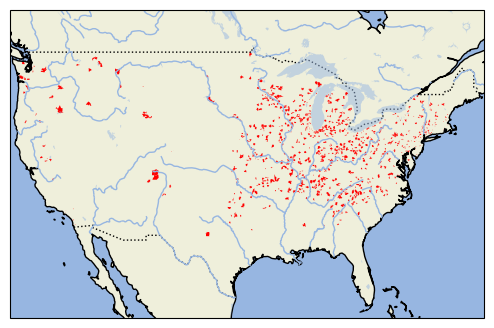

In [42]:
# Define the Cartopy CRS (Coordinate Reference System) for the continental US.
# PlateCarree is a simple geographical projection
projection = ccrs.PlateCarree()

# ZCTAs with more than one morel sighting
fig, ax = plt.subplots(figsize=(8, 4),
                       subplot_kw={'projection': projection})
ax.set_extent([-125, -66.5, 24, 49.5])

# Add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot your GeoJSON data
relevant_zctas.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')

plt.show()

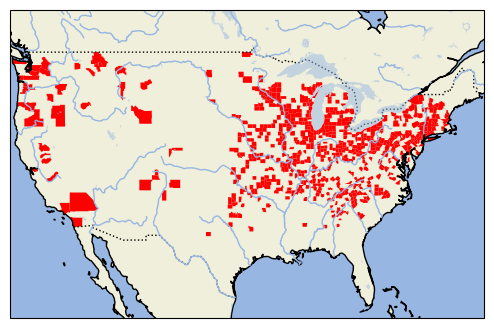

In [43]:
# FIPS boundaries with more than one morel sighting
fig, ax = plt.subplots(figsize=(8, 4),
                       subplot_kw={'projection': projection})
ax.set_extent([-125, -66.5, 24, 49.5])

# Add features to the map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot your GeoJSON data
relevant_fips.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')

plt.show()

In [44]:
relevant_training_columns = ['group', 'date_dateobj', 'time_idx', 'ppt', 'tmax', 'tmin', 'tavg', 'day_length_seconds', 'observation', 'final_target', 'final_gaussian_target', 'zcta_centroid_longitude', 'zcta_centroid_latitude']
train = []
for year in range(2018, 2024):
    data = create_training_data(year, data_path)
    summary_stats = data.agg({
        'date': ['max', 'min'],
        'ppt': ['mean', 'min', 'max', 'median'],
        'tmax': ['mean', 'min', 'max', 'median'],
        'tmin': ['mean', 'min', 'max', 'median'],
        'tavg': ['mean', 'min', 'max', 'median'],
        'zcta_centroid_longitude': ['max', 'min'],
        'zcta_centroid_latitude': ['max', 'min'],
        'observation': ['max', 'min', 'mean'],
        'time_idx': ['max', 'min'],
        'target': ['max', 'min', 'mean'],
        'final_target': ['max', 'min', 'mean'],
        'final_gaussian_target': ['max', 'min', 'mean'],
        'day_length_seconds': ['max', 'min', 'mean', 'median'],
    })
    print(summary_stats.head(300))
    train.append(data[relevant_training_columns])

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

954


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20180630  136.149000  38.997000  27.260000  32.485000   
min     20180101    0.000000 -25.387000 -35.145000 -29.709000   
mean         NaN    3.373149  13.767824   2.705621   8.236721   
median       NaN    0.000000  13.550000   1.418000   7.408000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -70.748230               48.854630     1.000000   
min                 -123.838592               30.572331     0.000000   
mean                        NaN                     NaN     0.006353   
median                      NaN                     NaN          NaN   

        time_idx    target  final_target  final_gaussian_target  \
max        181.0  1.000000      1.000000               1.000000   
min          1.0  0.000000      0.000000               0.000000   
mean         NaN  0.054683      0.055814               0.062021   
median       NaN       NaN           NaN     

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

1096


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20190630  183.815000  39.636000  27.921000  31.316000   
min     20190101    0.000000 -30.782000 -41.775000 -34.696000   
mean         NaN    3.730606  12.730886   2.077507   7.404197   
median       NaN    0.009000  13.339000   2.373000   7.850000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -69.301685               48.915307     1.000000   
min                 -123.424683               31.913490     0.000000   
mean                        NaN                     NaN     0.006347   
median                      NaN                     NaN          NaN   

        time_idx    target  final_target  final_gaussian_target  \
max        181.0  1.000000      1.000000               1.000000   
min          1.0  0.000000      0.000000               0.000000   
mean         NaN  0.054403      0.055774               0.062017   
median       NaN       NaN           NaN     

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

1152


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20200630  153.431000  40.374000  27.381000  30.891000   
min     20200101    0.000000 -21.403000 -35.300000 -27.024000   
mean         NaN    3.411414  14.500527   3.868457   9.184491   
median       NaN    0.007000  14.226000   2.793000   8.438000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -70.987742               48.483813     1.000000   
min                 -123.522135               30.049313     0.000000   
mean                        NaN                     NaN     0.006475   
median                      NaN                     NaN          NaN   

        time_idx    target  final_target  final_gaussian_target  \
max        182.0  1.000000      1.000000               1.000000   
min          1.0  0.000000      0.000000               0.000000   
mean         NaN  0.055285      0.057803               0.063954   
median       NaN       NaN           NaN     

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

961


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20210630  225.339000  44.046000  26.936000  34.062000   
min     20210101    0.000000 -24.370000 -40.057000 -31.921000   
mean         NaN    2.746141  13.797817   2.923175   8.360497   
median       NaN    0.000000  14.597000   2.284000   8.530000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -67.728176               48.715904     1.000000   
min                 -123.340217               30.218945     0.000000   
mean                        NaN                     NaN     0.006107   
median                      NaN                     NaN          NaN   

        time_idx   target  final_target  final_gaussian_target  \
max        181.0  1.00000      1.000000               1.000000   
min          1.0  0.00000      0.000000               0.000000   
mean         NaN  0.05345      0.055025               0.061031   
median       NaN      NaN           NaN          

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

1154


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20220630  148.900000  40.360000  28.396000  32.977000   
min     20220101    0.000000 -27.111000 -37.755000 -30.585000   
mean         NaN    2.959573  13.707093   2.172755   7.939925   
median       NaN    0.000000  14.178000   2.027000   8.153000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -68.883965               48.593276      1.00000   
min                 -124.474761               30.860166      0.00000   
mean                        NaN                     NaN      0.00627   
median                      NaN                     NaN          NaN   

        time_idx    target  final_target  final_gaussian_target  \
max        181.0  1.000000      1.000000                1.00000   
min          1.0  0.000000      0.000000                0.00000   
mean         NaN  0.054241      0.055835                0.06195   
median       NaN       NaN           NaN     

/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/3573263481.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  new_bounds[f"{prefix}_centroid"] = new_bounds["geometry"].centroid
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/239812245.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  processed_observations = load_and_preprocess_observations(year, data_path, fips_bounds_processed, zcta_bounds_

1172


/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/603190514.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('ZCTA5CE10').apply(lambda group: apply_rolling(group, window=window_size)).reset_index(drop=True)
/var/folders/vx/cn9l4fq15398wj11q3fp93zm0000gn/T/ipykernel_17392/761266414.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return weather_data.groupby('Z

            date         ppt       tmax       tmin       tavg  \
max     20230630  142.043000  44.161000  27.249000  34.080000   
min     20230101    0.000000 -24.160000 -35.193000 -29.609000   
mean         NaN    2.800598  15.039294   3.621376   9.330336   
median       NaN    0.000000  15.283000   3.043000   9.150000   

        zcta_centroid_longitude  zcta_centroid_latitude  observation  \
max                  -70.060823               48.808862     1.000000   
min                 -123.607690               31.880959     0.000000   
mean                        NaN                     NaN     0.006343   
median                      NaN                     NaN          NaN   

        time_idx    target  final_target  final_gaussian_target  \
max        181.0  1.000000      1.000000               1.000000   
min          1.0  0.000000      0.000000               0.000000   
mean         NaN  0.054785      0.056541               0.062729   
median       NaN       NaN           NaN     

In [47]:
# Concatenate all training data into single unified dataset
all_train_data = pd.concat(train)

In [48]:
all_train_data.describe()

,date_dateobj,time_idx,ppt,tmax,tmin,tavg,day_length_seconds,observation,final_target,final_gaussian_target,zcta_centroid_longitude,zcta_centroid_latitude
count,1018551,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06,1.018551e+06
mean,2020-11-02 15:41:22.751673344,9.108657e+01,3.166550e+00,1.394278e+01,2.903927e+00,8.423353e+00,4.504480e+04,6.318780e-03,5.616508e-02,6.231780e-02,-8.735646e+01,4.038926e+01
min,2018-01-01 00:00:00,1.000000e+00,0.000000e+00,-3.078200e+01,-4.177500e+01,-3.469600e+01,2.995455e+04,0.000000e+00,0.000000e+00,0.000000e+00,-1.244748e+02,3.004931e+01
25%,2019-04-22 00:00:00,4.600000e+01,0.000000e+00,5.393000e+00,-3.551000e+00,1.000000e+00,3.848712e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.119120e+01,3.846079e+01
50%,2021-01-15 00:00:00,9.100000e+01,0.000000e+00,1.422900e+01,2.413000e+00,8.310000e+00,4.556820e+04,0.000000e+00,0.000000e+00,0.000000e+00,-8.582276e+01,4.052794e+01
75%,2022-04-21 00:00:00,1.360000e+02,2.388000e+00,2.333000e+01,1.075300e+01,1.695600e+01,5.179105e+04,0.000000e+00,0.000000e+00,0.000000e+00,-8.134148e+01,4.246279e+01
max,2023-06-30 00:00:00,1.820000e+02,2.253390e+02,4.416100e+01,2.839600e+01,3.408000e+01,5.823500e+04,1.000000e+00,1.000000e+00,1.000000e+00,-6.772818e+01,4.891531e+01
std,NaN,5.229987e+01,7.613750e+00,1.114523e+01,1.010481e+01,1.042856e+01,7.104325e+03,7.923925e-02,2.302403e-01,2.061681e-01,1.039234e+01,3.197654e+00


In [49]:
all_train_data.isnull().sum()

group                      0
date_dateobj               0
time_idx                   0
ppt                        0
tmax                       0
tmin                       0
tavg                       0
day_length_seconds         0
observation                0
final_target               0
final_gaussian_target      0
zcta_centroid_longitude    0
zcta_centroid_latitude     0
dtype: int64

In [57]:
all_train_data.to_pickle(f'{data_path}processed/timeseries_2018_through_2023_with_raw_observation.pkl')

In [58]:
train_set = pd.read_pickle(f'{data_path}processed/timeseries_2018_through_2023_with_raw_observation.pkl')

In [63]:
all_train_data.to_csv(f'{data_path}processed/timeseries_2018_through_2023_with_raw_observation.csv', index= False)